In [2]:
"""
Script (do not modify)

Set up environment and library
"""
import numpy as np
import cv2
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
!pip install -U opencv-contrib-python==3.4.2.17
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 30.6 MB 1.7 MB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.6.0.66
    Uninstalling opencv-contrib-python-4.6.0.66:
      Successfully uninstalled opencv-contrib-python-4.6.0.66


In [3]:
"""
Script (do not modify)

Upload yosemite1.jpg, yosemite2.jpg, board_tilted_view.jpg to current
notebook working session.
"""
# upload images 
from google.colab import files
uploaded = files.upload()

Saving board_tilted_view.jpg to board_tilted_view.jpg
Saving yosemite1.jpg to yosemite1.jpg
Saving yosemite2.jpg to yosemite2.jpg


In [4]:
'''
Function (modify)
'''
def compute_homography(p1, p2):	
  """
  Compute homography transform matrix given 4 pairs of corresponding points

  Input:
  p1, p2: (4,2) shape of 4 corresponding points

  Output:
  H: (3,3) shape of homography matrix such that lambda * p1 = H @ p2
  """	
  # IMPLEMENT HERE 
  # 1) Construct the A matrix shown in Figure 1 in the instruction file

  # 2) Use SVD to find the solution vector h such that Ah = 0 (Hint: you may find np.linalg.svd useful)

  # 3) Reorgnize the solution vector and normalize it to get homography matrix

  X = np.array(p2)
  X_prime = np.array(p1)

  A = np.zeros([X_prime.shape[0]*2, 9])
    
  for i in range(0,X_prime.shape[0]):
      x,y = X[i]
      x_dash, y_dash = X_prime[i]
      a_x = [-x, -y, -1, 0, 0, 0, x*x_dash, y*x_dash, x_dash]
      a_y = [0, 0, 0, -x, -y, -1, x*y_dash, y*y_dash, y_dash]
      A[2*i] = a_x
      A[2*i+1] = a_y

   #print(A.shape)
    
  H = np.zeros([9,0])
    
  [U, S, Vt] = np.linalg.svd(A)
  V = np.transpose(Vt)
  H = V[:,-1]
  H = H/H[-1]

  #import scipy
  #H = scipy.linalg.null_space(A)
    
  H = np.reshape(H,[3,3])
  #print(H)

  return H

In [5]:
## Test ##
p1 = np.array([[366.6972,  106.9789],
  [439.9366,   84.4437],
  [374.5845,  331.2042],
  [428.6690,  326.6972]])

p2 = np.array([ (115.0000,  120.0000),
  [194.0000,  107.0000],
  [109.0000,  351.0000],
  [169.0000,  346.0000] ])

H = compute_homography(p1, p2)

#print(H)

assert np.allclose(H, np.array([[ 6.76097539e-01,  9.12020085e-02,  2.61445474e+02],
       [-1.57581282e-01,  9.59039559e-01,  5.18593524e+00],
       [-4.93549913e-04,  9.67378471e-05,  1.00000000e+00]]))

In [6]:
"""
Function (modify)
"""
def match_features(f1, f2):
  """
  Match two sets of features

  Input:
  f1, f2: (N, feature_size) shape of features to be matched

  Output:
  match, match_fwd, match_bkwd: (N, 2) shape of final matching result, forward matching result and backward matching result
  For each matching result, the first column is the index in f1 and the second column is the index in f2
  """
  # IMPLEMENT HERE (Hint: you may find cdist from scipy.spatial.distance, numpy.take_along_axis, numpy.take_along_axis useful)
  # 1) Compute pairwise distance between f1 and f2 

  # 2) Perform forward matching, find closet two matches in f2 to f1 and do a ratio test

  # 3) Perform backward matching, find closet two matches in f1 to f2 and do a ratio test

  # 4) Get the intersection of two matching as the final matching result

  from scipy.spatial import distance
  d = distance.cdist(f1, f2, 'euclidean')
  #print('d: ', d)

  threshold = 0.7

  #Forward matching
  idx = np.argsort(d, axis = 1)
  ratio = np.take_along_axis(d, idx[:,0:1], axis=1) / np.take_along_axis(d, idx[:,1:2], axis=1)
  #print(idx.shape)
  forward_idx = []
  for i in range(0, idx.shape[0]):
    if ratio[i,0] < threshold: 
      forward_idx.append([i, idx[i,0]])
  
  #Backward matching
  idx = np.argsort(d, axis = 0)
  ratio = np.take_along_axis(d, idx[0:1,:], axis=0) / np.take_along_axis(d, idx[1:2,:], axis=0)
  #print('idx: ', idx)
  backward_idx = []
  for i in range(0, idx.shape[1]):
    if ratio[0,i] < threshold: 
      backward_idx.append([idx[0,i], i])

  #Intersection
  intersect = set(map(tuple, forward_idx)) & set(map(tuple, backward_idx))
  #print(intersect)

  match = np.array([i for i in intersect])
  match_fwd = np.array(forward_idx)
  match_bkwd = np.array(backward_idx)

  #print('match: ', match)
  #print('match_fwd: ', match_fwd)
  #print('match_bkwd: ', match_bkwd)

  return match, match_fwd, match_bkwd

In [7]:
## Test ##
a = np.array([[2, 3],[5, 8],[4, 10]])
b = np.array([[10, 2],[2, 3],[5, 7],[1, -10]])
match, match_fwd, match_bkwd = match_features(a, b)
assert np.allclose(match, np.array([[0, 1],[1, 2]]))
assert np.allclose(match_fwd, np.array([[0, 1],[1, 2],[2, 2]]))
assert np.allclose(match_bkwd, np.array([[0, 1],[1, 2]]))

In [8]:
"""
Function (modify)
"""
def ransac_homography(p1, p2):
  """
  Estimate homography matrix with RANSAC
  
  Input:
  p1, p2: (N, 2) shape of correponding points

  Output:
  H: (3, 3) shape of estimated homography matrix such that lambda * p1 = H @ p2
  """
  # IMPLEMENT HERE
  # Decide how many loops to run and what the threshold is

  # RANSAC loop, inside in the loop
  #     1) Randomly pick n samples from p1 and p2 that is enough to fit a model (n=4 here)

  #     2) Fit the model and get a estimation

  #     3) Count consensus(# of inliners that is close to the estimatiion within the threshold)

  #     4) Update the best estimation if the current one is better 

  #k = log(1-p) / log(1 - w^n)
  # k = num_iterations, p = rate of success, w = prob of choosing inlier, n = number of points chosen

  p1 = np.array(p1)
  p2 = np.array(p2)

  p = 1 - 1e-4
  w = 0.5
  n = 4
  k = np.log(1-p)/np.log(1-np.power(w,n))
  #print(k)

  best_match_count = 0
  best_H = np.zeros([3,3])

  num_iterations = int(k)
  for i in range(0, num_iterations):
    n = 4 #Number of samples per model

    N = p1.shape[0]
    idx = np.array(np.random.choice(N, n, replace = False))
    p1_dash = p1[idx]
    p2_dash = p2[idx]

    H = compute_homography(p1_dash, p2_dash)

    p2_h = np.hstack((p2, np.ones((p2.shape[0], 1))))
    
    p1_h = (H @ p2_h.T).T
    p1_h = p1_h[:, :2] / p1_h[:, -1, None]

    match, match_fwd, match_bkwd = match_features(p1_h, p1)

    ct = match.shape[0]
    if ct > best_match_count:
      best_H = H
      best_match_count = ct

    #print('H: ', H, '\n')
    #print('best_H: ', best_H, '\n\n')

  return best_H

In [11]:
## Test ##
p2 = np.random.randint(20, 200, size=(10, 2))
p2_ = np.hstack((p2, np.ones((10, 1)))).T
H = np.array([[ 6.76097539e-01,  9.12020085e-02,  2.61445474e+02],
       [-1.57581282e-01,  9.59039559e-01,  5.18593524e+00],
       [-4.93549913e-04,  9.67378471e-05,  1.00000000e+00]])
p1_ = H @ p2_
p1 = p1_ / p1_[-1, :]
p1 = p1[:2]
p1[:, -3:] += 50
p1 = p1.T
assert np.allclose(H, ransac_homography(p1, p2))

In [12]:
"""
Function (do not modify)
"""
def plot_corr(I1, I2, p1, p2):
  """
  utility function to plot correspondence between p1 in I1 and p2 in I2

  I1, I2: H * W, two input images of the same size
  p1, p2: N * 2, points on two images 
  """
  I = np.hstack((I1, I2))
  sy,sx = I1.shape[0:2]

  plt.figure()
  plt.title('Correspondence result')
  plt.imshow(I)
  plt.plot(p1[:, 0], p1[:, 1],'bo')
  plt.plot(sx + p2[:, 0], p2[:, 1],'rx')
  plt.plot(np.c_[p1[:, 0], sx + p2[:, 0]].T, np.c_[p1[:, 1],p2[:, 1]].T,'g-')
  plt.show() 

In [13]:
"""
Function (do not modify)
"""
def stitch(I1, I2, H):
    """
    utility function to stitch two images

    Input:

    I1: H1 x W1 x 3, target image
    I2: H2 x W2 x 3, source image
    H: homography matrix such that I1 = H @ I2

    Output:
    I_: stitching result
    """
    eps = 1e-7
    sy1, sx1, sz1 = I1.shape
    sy2, sx2, sz2 = I2.shape
    x2, y2 = np.meshgrid(np.arange(sx2), np.arange(sy2))
    # map I2 to I1
    p1_hat = H @ np.r_[x2.ravel(), y2.ravel(), np.ones_like(x2.ravel())].reshape(3, -1)
    p1_hat = p1_hat[0:2] / (p1_hat[2] + eps)

    # create new dimensions to accomodate points from I2
    p1_hat_xmax = np.max(p1_hat[0])
    p1_hat_xmin = np.min(p1_hat[0])
    p1_hat_ymax = np.max(p1_hat[1])
    p1_hat_ymin = np.min(p1_hat[1])

    xmin = np.rint(np.floor(np.minimum(p1_hat_xmin, 0))).astype(np.int32)
    xmax = np.rint(np.ceil(np.maximum(p1_hat_xmax, sx2))).astype(np.int32)
    ymin = np.rint(np.floor(np.minimum(p1_hat_ymin, 0))).astype(np.int32)
    ymax = np.rint(np.ceil(np.maximum(p1_hat_ymax, sy2))).astype(np.int32)

    # create images for mapping
    I1_ = np.zeros((ymax - ymin, xmax - xmin, 3), dtype=np.uint8)
    I2_ = np.zeros((ymax - ymin, xmax - xmin, 3), dtype=np.uint8)
    I_ = np.zeros((ymax - ymin, xmax - xmin, 3), dtype=np.uint8)

    # I1 is just translated in I_
    I1_[-ymin:sy1 - ymin, -xmin:sx1 - xmin, :] = I1[:min(sy1, ymax), :min(sx1, xmax), :]

    # map I_ to I2 (translation then homography)
    sy2_, sx2_, sz2_ = I2_.shape
    x2_, y2_ = np.meshgrid(np.arange(sx2_), np.arange(sy2_))
    p2_hat = np.linalg.inv(H) @ np.r_[x2_.ravel() + xmin, y2_.ravel() + ymin, np.ones(x2_.size)].reshape(3, -1)
    p2_hat = np.rint(p2_hat[0:2] / (p2_hat[2] + eps)).astype(np.int32)

    # keep only the valid coordinates of I2
    good_x = np.logical_and(p2_hat[0, :] >= 0, p2_hat[0, :] < sx2)
    good_y = np.logical_and(p2_hat[1, :] >= 0, p2_hat[1, :] < sy2)
    good = np.logical_and(good_x, good_y)


    # I2 transformed by homography in I_
    I2_[y2_[good.reshape(x2_.shape)], x2_[good.reshape(x2_.shape)]] = I2[p2_hat[1, good], p2_hat[0, good]]

    # nonoverlapping regions do not require blending
    I2_sum = np.sum(I2_, axis=2)
    I1_sum = np.sum(I1_, axis=2)

    # in no blend area, one of I1_ and I2_ is all 0 
    no_blend_area = np.logical_or(I2_sum == 0, I1_sum == 0)
    I_[no_blend_area] = I2_[no_blend_area] + I1_[no_blend_area]

    # in blend area, take the average of I1_ and I2_
    blend_area = np.logical_and(I2_sum > 0, I1_sum > 0)
    I_[blend_area] = (I1_[blend_area] * .5 + I2_[blend_area] * .5).astype(np.uint8)
    return I_

## Plot correspondence result and stitched image

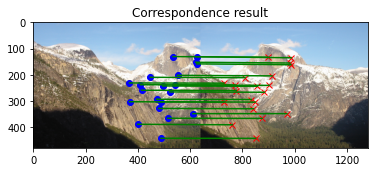

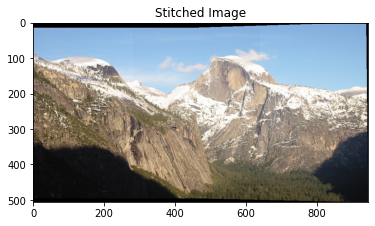

In [14]:
"""
Script (do not modify)
"""

# load images in OpenCV BGR format
I1 = cv2.imread('yosemite1.jpg')
I2 = cv2.imread('yosemite2.jpg')

# create grayscale images
I1_gray = cv2.cvtColor(I1, cv2.COLOR_BGR2GRAY)
I2_gray = cv2.cvtColor(I2, cv2.COLOR_BGR2GRAY);

# convert images to RGB format for display
I1 = cv2.cvtColor(I1, cv2.COLOR_BGR2RGB)
I2 = cv2.cvtColor(I2, cv2.COLOR_BGR2RGB)

# compute SIFT features
sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(I1_gray, None)
kp2, des2 = sift.detectAndCompute(I2_gray, None)

# match features
match, match_fwd, match_bkwd = match_features(des1, des2)

# get corresponding points p1, p2 
p1 = np.array([kp.pt for kp in kp1])[match[:, 0]]
p2 = np.array([kp.pt for kp in kp2])[match[:, 1]]

# plot first 20 matching points 
plot_corr(I1, I2, p1[:20], p2[:20])

# estimate homography transform with RANSAC
H = ransac_homography(p1, p2)

# stitch two images together and show the results
I = stitch(I1,I2,H)
plt.figure()
plt.imshow(I)
plt.title('Stitched Image')
plt.show()

## Image Perspective Correction

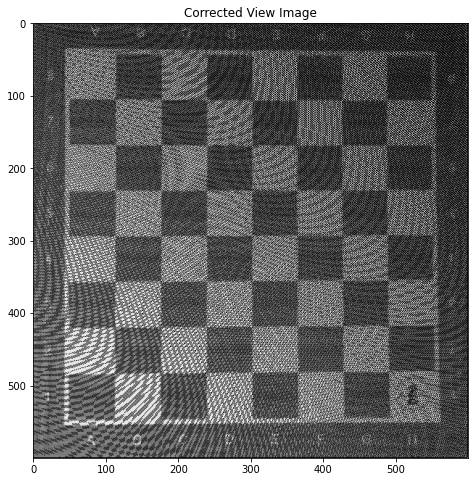

In [20]:
###### NO NEED TO MODIFY #########
# Four corner coordinates of the board in titled view image
img_tilted = cv2.imread('board_tilted_view.jpg',0)
pt_A = np.array([38, 286])
pt_B = np.array([483, 583])
pt_C = np.array([964, 310])
pt_D = np.array([510, 112])
##################################

###### IMPLEMENT START HERE ######
# 1. Construct a blank canvas for the corrected view image (No need to modify)
width, height = 600, 600
#width, height = 300, 300
canvas = np.zeros((height, width))

# 2. Find the corresponding four corner coordinates of the board in the correct view image
p1 = np.vstack([pt_A, pt_B, pt_C, pt_D]) #titled image corners
#p2 = [[100,500], [500, 500], [500, 100], [100, 100]]
p2 = [[0,0], [0, 599], [599, 599], [599,0]]
p2_corners = p2

# 3. Find the homography transformation matrix H between tilted view and corrected view using the two sets of corner points

H = ransac_homography(p2, p1)

# 4. Construct the homogeneous coordinates P2 of all pixels in corrected view (Hint: meshgrid)

from matplotlib.path import Path
#edges = [ [0,0], [0, img_tilted.shape[1]], [img_tilted.shape[0], img_tilted.shape[1]], [img_tilted.shape[0], 0]]
path = Path(p1)
image_size = img_tilted.shape
xx, yy = np.meshgrid(range(image_size[1]), range(image_size[0]))
xxyy = np.stack([xx.ravel(), yy.ravel()], 1)

interior_ind = path.contains_points(xxyy)
interior_pts = xxyy[interior_ind]
#print(interior_pts.shape)

p1_h = np.hstack((interior_pts, np.ones((interior_pts.shape[0], 1))))
    
p2_h = (H @ p1_h.T).T
p2_h = p2_h[:, :2] / p2_h[:, -1, None]
p2 = p2_h

#print(p2.shape)

# 5. Perform inverse warping to find warped pixel coordinate P1 in titled view image plane corresponding to P2

#print(np.linalg.inv(H).shape)

p2_h = np.hstack((p2, np.ones((p2.shape[0], 1))))
#tmp = H
tmp = np.linalg.inv(H)
p1 = np.matmul(tmp, p2_h.T).T
p1 = p1[:,:2]/ p1[:,-1, None]

#print(p1.shape)


# 6. With the warped pixel coordinates P1, extract pixel values from titled view image and fill in the blank canvas to form corrected view image

canvas = np.array(canvas)

#print(np.max(p1[:,0]))
#print(np.max(p1[:,1]))
#print(img_tilted.shape)

tmp0 = np.max(p2[:,0])
tmp1 = np.max(p2[:,1])

p2[:,0] = p2[:,0]/tmp0*canvas.shape[0]
p2[:,1] = p2[:,1]/tmp1*canvas.shape[1]

for i in range(0, p1.shape[0]):
  canvas[int(p2[i,1] - 1), int(p2[i,0] - 1)] = img_tilted[int(p1[i,1]), int(p1[i,0])]


# Finally, plot the corrected view image
plt.figure(figsize=(8,8))
plt.title('Corrected View Image')
plt.imshow(canvas,cmap='gray')

In [32]:
def interp2(v, xq, yq):
	dim_input = 1
	if len(xq.shape) == 2 or len(yq.shape) == 2:
		dim_input = 2
		q_h = xq.shape[0]
		q_w = xq.shape[1]
		xq = xq.flatten()
		yq = yq.flatten()

	h = v.shape[0]
	w = v.shape[1]
	if xq.shape != yq.shape:
		raise 'query coordinates Xq Yq should have same shape'

	x_floor = np.floor(xq).astype(np.int32)
	y_floor = np.floor(yq).astype(np.int32)
	x_ceil = np.ceil(xq).astype(np.int32)
	y_ceil = np.ceil(yq).astype(np.int32)

	x_floor[x_floor < 0] = 0
	y_floor[y_floor < 0] = 0
	x_ceil[x_ceil < 0] = 0
	y_ceil[y_ceil < 0] = 0

	x_floor[x_floor >= w-1] = w-1
	y_floor[y_floor >= h-1] = h-1
	x_ceil[x_ceil >= w-1] = w-1
	y_ceil[y_ceil >= h-1] = h-1

	v1 = v[y_floor, x_floor]
	v2 = v[y_floor, x_ceil]
	v3 = v[y_ceil, x_floor]
	v4 = v[y_ceil, x_ceil]

	lh = yq - y_floor
	lw = xq - x_floor
	hh = 1 - lh
	hw = 1 - lw

	w1 = hh * hw
	w2 = hh * lw
	w3 = lh * hw
	w4 = lh * lw

	interp_val = v1 * w1 + w2 * v2 + w3 * v3 + w4 * v4

	if dim_input == 2:
		return interp_val.reshape(q_h, q_w)
	return interp_val



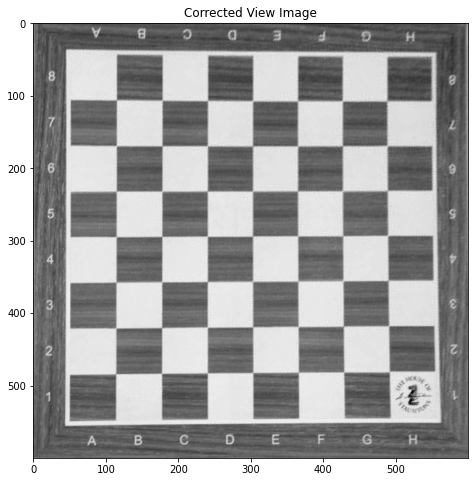

In [36]:
###### NO NEED TO MODIFY #########
# Four corner coordinates of the board in titled view image
img_tilted = cv2.imread('board_tilted_view.jpg',0)
pt_A = np.array([38, 286])
pt_B = np.array([483, 583])
pt_C = np.array([964, 310])
pt_D = np.array([510, 112])
##################################

###### IMPLEMENT START HERE ######

# 1. Construct a blank canvas for the corrected view image (No need to modify)
width, height = 600, 600
canvas = np.zeros((height, width))

# 2. Find the corresponding four corner coordinates of the board in the correct view image
p1 = np.vstack([pt_A, pt_B, pt_C, pt_D])
p1 = p1[:, ::-1]

p2 = np.array([[0, 0], [599, 0], [599, 599], [0, 599]])

# # 3. Find the homography transformation matrix H between tilted view and corrected view using the two sets of corner points
H = ransac_homography(p1, p2)

# # 4. Construct the homogeneous coordinates P2 of all pixels in corrected view (Hint: meshgrid)

y, x = np.meshgrid(range(height), range(width))
stack = np.vstack((y.ravel(), x.ravel(), np.ones(x.size)))


p1 = H @ stack
p1 = p1 / p1[2]

canvas[y.ravel(), x.ravel()] = interp2(img_tilted, p1[1], p1[0])

# Finally, plot the corrected view image
plt.figure(figsize=(8,8))
plt.title('Corrected View Image')
plt.imshow(canvas,cmap='gray')